# Integrated Stress Testing and Capital Adequacy

Bring together **credit**, **market**, **liquidity**, and **operational/model** risk components into a
single stress-testing framework. Compute post-stress **CET1** and **Leverage** ratios, and compare
scenarios against illustrative regulatory thresholds.

## Learning Objectives
- Define coherent **macro scenarios** and translate them into shocks across risk stripes.
- Estimate credit losses using a **Vasicek/ASRF-style** approximation (segment-based) with PD/LGD multipliers.
- Add **market VaR/ES-style** losses and **operational** lognormal shocks.
- Include **liquidity** shortfalls via 30‑day net outflows vs **HQLA** with a simple fire‑sale CET1 impact.
- Roll up to **post-stress CET1**/**Leverage** and compare to thresholds.

## Setup

In [12]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, lognorm

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
rng = np.random.default_rng(2025)


## Base Balance Sheet & Risk Parameters (Illustrative)

In [13]:
# Balance sheet (in £m)
assets = {
    'Cash & Reserves': 200.0,
    'HQLA Level1': 300.0,
    'Prime Mortgages': 600.0,
    'Retail Unsecured': 250.0,
    'Corporate Loans (BBB)': 450.0,
    'Trading Book / Securities': 300.0,
}

liabilities = {
    'Customer Deposits': 1_550.0,
    'Wholesale Funding <1Y': 250.0,
    'Senior Debt ≥1Y': 200.0,
}

# Capital
CET1 = 120.0  # £m

# Risk weights (stylised, for Pillar 1-style sensitivity)
risk_weights = {
    'Cash & Reserves': 0.00,
    'HQLA Level1': 0.00,
    'Prime Mortgages': 0.35,
    'Retail Unsecured': 0.75,
    'Corporate Loans (BBB)': 1.00,
    'Trading Book / Securities': 1.00,
}

# Liquidity settings
HQLA_haircut = 0.00  # Level 1 only in this toy set
inflows_30 = 30.0    # £m
outflows_30 = 60.0   # £m (pre-stress)
inflow_cap = 0.75
FIRE_SALE_COST_RATE = 0.10  # fraction of shortfall recognised as CET1 cost

# Regulatory thresholds (illustrative)
MIN_CET1_RATIO = 0.045  # Pillar 1 minimum
CCB = 0.025             # capital conservation buffer
TARGET_CET1_RATIO = MIN_CET1_RATIO + CCB
MIN_LEVERAGE = 0.035


## Macro Scenarios and Shock Parameters

In [14]:
scenarios = pd.DataFrame([
    {
        'Name':'Baseline',
        'PD_mult':1.00, 'LGD_mult':1.00, 'Credit_rho':0.10,
        'Market_sigma_mult':1.00, 'Market_horizon_days':10, 'Market_alpha':0.99,
        'RW_multiplier':1.00,
        'Liquidity_intensity':0.10,  # mild deposit pressure
        'Op_mu':12.0, 'Op_sigma':0.7, 'Op_quantile':0.99,
    },
    {
        'Name':'Adverse',
        'PD_mult':1.35, 'LGD_mult':1.05, 'Credit_rho':0.15,
        'Market_sigma_mult':1.50, 'Market_horizon_days':10, 'Market_alpha':0.99,
        'RW_multiplier':1.15,
        'Liquidity_intensity':0.25,
        'Op_mu':12.5, 'Op_sigma':0.9, 'Op_quantile':0.995,
    },
    {
        'Name':'Severe',
        'PD_mult':1.85, 'LGD_mult':1.10, 'Credit_rho':0.20,
        'Market_sigma_mult':2.20, 'Market_horizon_days':10, 'Market_alpha':0.995,
        'RW_multiplier':1.30,
        'Liquidity_intensity':0.40,
        'Op_mu':13.0, 'Op_sigma':1.0, 'Op_quantile':0.999,
    },
])
scenarios

,Name,PD_mult,LGD_mult,Credit_rho,Market_sigma_mult,Market_horizon_days,Market_alpha,RW_multiplier,Liquidity_intensity,Op_mu,Op_sigma,Op_quantile
0,Baseline,1.0000,1.0000,0.1000,1.0000,10,0.9900,1.0000,0.1000,12.0000,0.7000,0.9900
1,Adverse,1.3500,1.0500,0.1500,1.5000,10,0.9900,1.1500,0.2500,12.5000,0.9000,0.9950
2,Severe,1.8500,1.1000,0.2000,2.2000,10,0.9950,1.3000,0.4000,13.0000,1.0000,0.9990


## Helper Functions

In [15]:
def total_assets(assets: dict) -> float:
    return float(sum(assets.values()))

def total_liabs(liabs: dict) -> float:
    return float(sum(liabs.values()))

def compute_rwa(assets: dict, rw: dict) -> float:
    return float(sum(assets[k]*rw.get(k,0.0) for k in assets))

def leverage_exposure(assets: dict) -> float:
    # Toy: on-balance-sheet exposures only
    return total_assets(assets)

def vasicek_UL_per_EAD(pd, lgd, rho, alpha):
    # UL per unit EAD using Basel ASRF closed-form (without maturity adj)
    pd = np.clip(pd, 1e-8, 1-1e-8)
    z = (norm.ppf(pd) + math.sqrt(rho)*norm.ppf(alpha)) / math.sqrt(1.0 - rho)
    loss_var = lgd*norm.cdf(z)
    el = pd*lgd
    ul = np.maximum(loss_var - el, 0.0)
    return el, ul, loss_var

def credit_segments():
    # Segment EADs from balance sheet buckets
    return [
        {'name':'Prime Mortgages', 'EAD': assets['Prime Mortgages'], 'PD':0.02, 'LGD':0.25},
        {'name':'Retail Unsecured', 'EAD': assets['Retail Unsecured'], 'PD':0.08, 'LGD':0.75},
        {'name':'Corporate Loans (BBB)', 'EAD': assets['Corporate Loans (BBB)'], 'PD':0.04, 'LGD':0.45},
    ]

def credit_losses_vasicek(segments, alpha, rho, pd_mult=1.0, lgd_mult=1.0):
    total_EL = 0.0
    total_UL = 0.0
    total_VaR = 0.0
    detail = []
    for seg in segments:
        E = seg['EAD']
        pd0 = seg['PD'] * pd_mult
        lgd0 = min(0.99, seg['LGD'] * lgd_mult)
        el, ul, var_per = vasicek_UL_per_EAD(pd0, lgd0, rho, alpha)
        detail.append({'Segment': seg['name'], 'EAD':E, 'EL_per':el, 'UL_per':ul, 'VaR_per':var_per})
        total_EL += E * el
        total_UL += E * ul
        total_VaR += E * var_per
    return total_EL, total_UL, total_VaR, pd.DataFrame(detail)

def market_loss_var(assets: dict, sigma_mult: float, horizon_days: int, alpha: float):
    # Toy market risk on Trading/Securities bucket with normal VaR; scale by horizon sqrt(T)
    trading_ead = assets.get('Trading Book / Securities', 0.0)
    daily_sigma = 0.015 * sigma_mult  # 1.5% daily vol baseline
    z = norm.ppf(alpha)
    var = trading_ead * (z * daily_sigma * math.sqrt(horizon_days))
    return float(var)

def liquidity_shortfall(hqla_lvl1: float, inflows_30: float, outflows_30: float, intensity: float, inflow_cap: float=0.75):
    # Apply intensity to increase outflows and haircut inflows
    out_s = outflows_30 * (1.0 + 1.5*intensity)
    in_s = inflows_30 * (1.0 - 0.5*intensity)
    capped_in = min(in_s, out_s*inflow_cap)
    net_out = max(out_s - capped_in, 0.0)
    hqla_post = hqla_lvl1 * (1.0 - HQLA_haircut)
    shortfall = max(net_out - hqla_post, 0.0)
    LCR = (hqla_post / net_out) if net_out>0 else float('inf')
    return shortfall, LCR, {'Outflows_30':out_s, 'Inflows_30':in_s, 'NetOut_30':net_out, 'HQLA_post':hqla_post}

def op_loss(mu: float, sigma: float, q: float):
    # Lognormal quantile as stress op loss
    s = lognorm(s=sigma, scale=math.exp(mu))
    return float(s.ppf(q))


## Pre‑Stress Ratios

In [16]:
A0 = total_assets(assets)
L0 = total_liabs(liabilities)
RWA0 = compute_rwa(assets, risk_weights)
LR_exp0 = leverage_exposure(assets)
CET1_ratio0 = CET1 / RWA0
Leverage0 = CET1 / LR_exp0
pre = pd.Series({
    'Total Assets (£m)': A0,
    'Total Liabilities (£m)': L0,
    'CET1 (£m)': CET1,
    'RWA (£m)': RWA0,
    'CET1 Ratio': CET1_ratio0,
    'Leverage Ratio': Leverage0,
}, name='Pre-Stress')
pre

Total Assets (£m)        2,100.0000
Total Liabilities (£m)   2,000.0000
CET1 (£m)                  120.0000
RWA (£m)                 1,147.5000
CET1 Ratio                   0.1046
Leverage Ratio               0.0571
Name: Pre-Stress, dtype: float64

## Run Integrated Scenarios

In [17]:
rows = []
loss_breakdown = []
for _, sc in scenarios.iterrows():
    name = sc['Name']
    # Credit
    EL_c, UL_c, VaR_c, cred_table = credit_losses_vasicek(
        credit_segments(), alpha=sc['Market_alpha'], rho=sc['Credit_rho'],
        pd_mult=sc['PD_mult'], lgd_mult=sc['LGD_mult']
    )
    credit_loss = VaR_c  # take VaR (EL+UL) as stress P&L hit

    # Market
    mkt_loss = market_loss_var(assets, sc['Market_sigma_mult'], sc['Market_horizon_days'], sc['Market_alpha'])

    # Operational
    opr_loss = op_loss(sc['Op_mu'], sc['Op_sigma'], sc['Op_quantile'])

    # Liquidity
    shortfall, LCR, liq_meta = liquidity_shortfall(assets['HQLA Level1'], inflows_30, outflows_30, sc['Liquidity_intensity'], inflow_cap)
    fire_sale_cost = shortfall * FIRE_SALE_COST_RATE

    # Capital and exposures post-stress (toy): deduct P&L losses and fire-sale cost from CET1; assets shrink by realized losses (ex liquidity shortfall itself)
    losses_pl = credit_loss + mkt_loss + opr_loss
    CET1_post = max(CET1 - losses_pl - fire_sale_cost, 0.0)
    A_post = max(A0 - losses_pl, 0.0)

    # Stressed RWA via multiplier
    RWA_post = RWA0 * sc['RW_multiplier']
    LR_exp_post = A_post

    cet1_ratio_post = CET1_post / RWA_post if RWA_post>0 else float('inf')
    leverage_post = CET1_post / LR_exp_post if LR_exp_post>0 else float('inf')

    rows.append({
        'Scenario': name,
        'Credit Loss VaR (£m)': credit_loss,
        'Market Loss VaR (£m)': mkt_loss,
        'Operational Loss (£m)': opr_loss,
        'Liquidity Shortfall (£m)': shortfall,
        'Fire Sale CET1 Cost (£m)': fire_sale_cost,
        'Total P&L Loss (£m)': losses_pl,
        'CET1 post (£m)': CET1_post,
        'RWA post (£m)': RWA_post,
        'Leverage Exposure post (£m)': LR_exp_post,
        'CET1 Ratio post': cet1_ratio_post,
        'Leverage Ratio post': leverage_post,
        'LCR (x)': LCR,
    })

    loss_breakdown.append(pd.DataFrame({
        'Scenario':[name]*3,
        'Component':['Credit','Market','Operational'],
        'Loss (£m)':[credit_loss, mkt_loss, opr_loss]
    }))

summary = pd.DataFrame(rows).set_index('Scenario')
loss_df = pd.concat(loss_breakdown, ignore_index=True)
summary

,Credit Loss VaR (£m),Market Loss VaR (£m),Operational Loss (£m),Liquidity Shortfall (£m),Fire Sale CET1 Cost (£m),Total P&L Loss (£m),CET1 post (£m),RWA post (£m),Leverage Exposure post (£m),CET1 Ratio post,Leverage Ratio post,LCR (x)
Scenario,,,,,,,,,,,,
Baseline,86.2136,33.1045,"829,388.1273",0.0000,0.0000,"829,507.4453",0.0000,"1,147.5000",0.0000,0.0000,inf,7.4074
Adverse,138.5160,49.6568,"2,725,728.7273",0.0000,0.0000,"2,725,916.9001",0.0000,"1,319.6250",0.0000,0.0000,inf,5.3333
Severe,234.9856,80.6403,"9,725,212.5782",0.0000,0.0000,"9,725,528.2041",0.0000,"1,491.7500",0.0000,0.0000,inf,4.1667


### Loss Components by Scenario

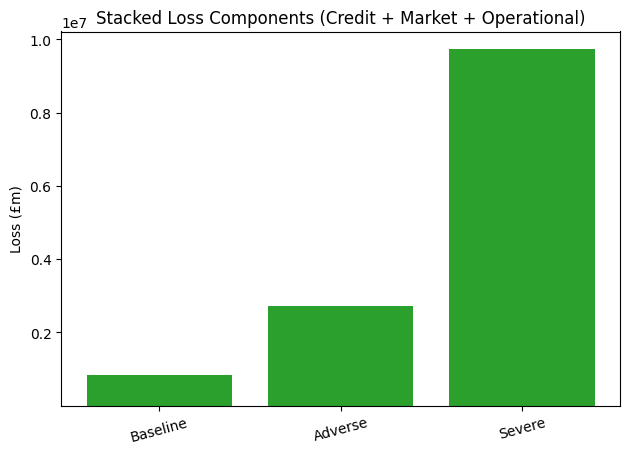

In [18]:
labels = summary.index.tolist()
cred = summary['Credit Loss VaR (£m)'].values
mkt = summary['Market Loss VaR (£m)'].values
opr = summary['Operational Loss (£m)'].values

x = np.arange(len(labels))
plt.figure()
plt.bar(x, cred)
plt.bar(x, mkt, bottom=cred)
plt.bar(x, opr, bottom=cred+mkt)
plt.xticks(x, labels, rotation=15)
plt.ylabel('Loss (£m)')
plt.title('Stacked Loss Components (Credit + Market + Operational)')
plt.tight_layout()
plt.show()


### Post‑Stress CET1 Ratio vs Threshold

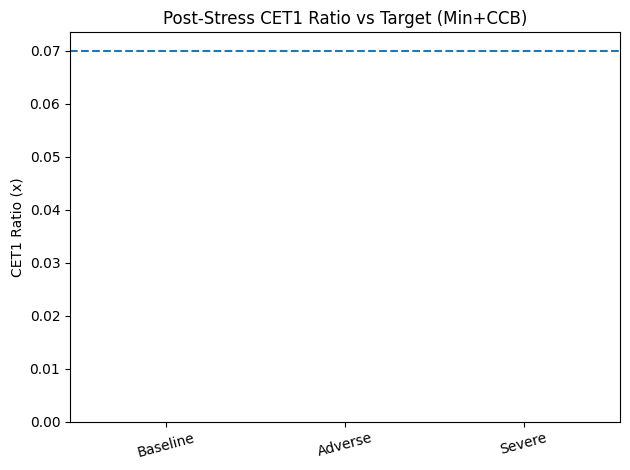

In [19]:
x = np.arange(len(summary.index))
vals = summary['CET1 Ratio post'].values
plt.figure()
plt.bar(x, vals)
plt.axhline(TARGET_CET1_RATIO, linestyle='--')
plt.xticks(x, summary.index, rotation=15)
plt.ylabel('CET1 Ratio (x)')
plt.title('Post‑Stress CET1 Ratio vs Target (Min+CCB)')
plt.tight_layout()
plt.show()


### Post‑Stress Leverage Ratio vs Minimum

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/matplotlib/transforms.py:2437: RuntimeWarning: invalid value encountered in dot
  return Affine2D(np.dot(self._b.get_affine().get_matrix(),


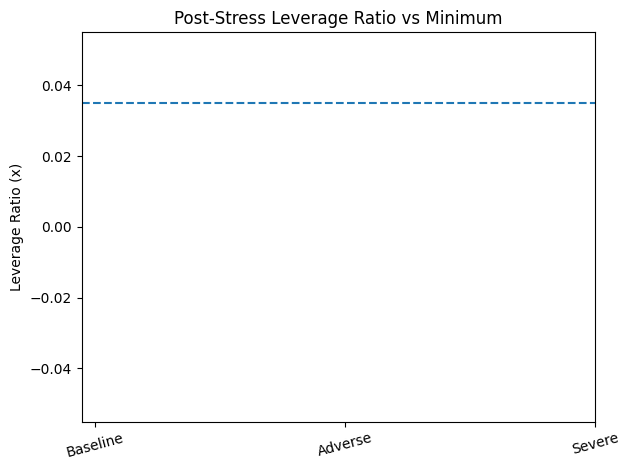

In [20]:
x = np.arange(len(summary.index))
vals = summary['Leverage Ratio post'].values
plt.figure()
plt.bar(x, vals)
plt.axhline(MIN_LEVERAGE, linestyle='--')
plt.xticks(x, summary.index, rotation=15)
plt.ylabel('Leverage Ratio (x)')
plt.title('Post‑Stress Leverage Ratio vs Minimum')
plt.tight_layout()
plt.show()


## Export Key Outputs

In [21]:

summary.to_csv('integrated_stress_summary.csv')
loss_df.to_csv('integrated_loss_components.csv', index=False)
pre.to_csv('integrated_pre_stress.csv')



---
### Notes & Extensions
- Credit uses a **segment-level ASRF approximation** (EL + UL at chosen confidence) as a stand-in for full loan-level MC.
- Market uses a **simple normal VaR** on a trading bucket; plug in your actual risk-factor VaR/ES if available.
- Liquidity applies a **30‑day net outflow** vs HQLA test with a CET1 fire‑sale cost; extend with secured funding and central bank lines.
- Operational loss is a **lognormal quantile**; replace with LDA or scenario layer from your OpRisk notebook.
- To integrate fully, import outputs from your other notebooks and replace these toy mappings, keeping the same interfaces.